# ISYE 6740 Final Project - omerkhan & afante3

In [176]:
import pandas as pd
import requests
import numpy as np
import nba_api.stats.endpoints as nba_stats
from nba_api.stats.endpoints import leagueleaders
from nba_api.stats.endpoints import commonplayerinfo
from nba_api.stats.endpoints import teamyearbyyearstats
from nba_api.stats.static import teams
import time
import concurrent.futures
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from nba_api.stats.endpoints import leaguestandings
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns

## Pre-processing steps needed to construct the dataset used for training.  However, you can skip ahead to model training which loads the equivalent data from a static file.

#### Using NBA Season data from 2010-2020

In [185]:
seasons = [
    '2010-11',
    '2011-12',
    '2012-13',
    '2013-14',
    '2014-15',
    '2015-16',
    '2016-17',
    '2017-18',
    '2018-19',
    '2019-20',
    '2020-21',
    '2021-22',
    '2022-23',
    #"2023-24"
]

#### Leveraging the NBA API, we can build a dataset of player and team information over our season period and calculate per game averages for each season and player across the period. The NBA_API can be viewed in further detail [here](https://github.com/swar/nba_api)

In [186]:
total_player_stats_df = pd.DataFrame()

for season in seasons:
    league_leaders = leagueleaders.LeagueLeaders(
      season=season,
      season_type_all_star="Regular Season",
      stat_category_abbreviation='PTS'
    ).get_data_frames()[0]

    league_leaders_df = league_leaders[['PLAYER_ID', 'PLAYER', 'TEAM_ID', 'TEAM', 'GP', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PTS', 'EFF', 'AST_TOV']]
    league_leaders_df = league_leaders_df.copy()
    league_leaders_df.loc[:, 'PPG'] = league_leaders_df['PTS'] / league_leaders_df['GP']
    league_leaders_df.loc[:, 'RPG'] = league_leaders_df['REB'] / league_leaders_df['GP']
    league_leaders_df.loc[:, 'APG'] = league_leaders_df['AST'] / league_leaders_df['GP']
    league_leaders_df.loc[:, 'SPG'] = league_leaders_df['STL'] / league_leaders_df['GP']
    league_leaders_df.loc[:, 'BPG'] = league_leaders_df['BLK'] / league_leaders_df['GP']
    league_leaders_df.loc[:, 'TPG'] = league_leaders_df['TOV'] / league_leaders_df['GP']
    league_leaders_df['YEAR'] = season

    league_leaders_pg_df = league_leaders_df[['YEAR', 'PLAYER_ID', 'PLAYER', 'TEAM_ID', 'TEAM', 'GP', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'EFF', 'AST_TOV', 'PPG', 'RPG', 'APG', 'SPG', 'BPG', 'TPG']]

    total_player_stats_df = pd.concat([total_player_stats_df, league_leaders_pg_df], sort=False)


In [187]:
total_player_stats_df
#total_player_stats_df[total_player_stats_df['PLAYER'] == "De'Aaron Fox"]

,YEAR,PLAYER_ID,PLAYER,TEAM_ID,TEAM,GP,FG_PCT,FG3_PCT,FT_PCT,EFF,AST_TOV,PPG,RPG,APG,SPG,BPG,TPG
0,2010-11,201142,Kevin Durant,1610612760,OKC,78,0.462,0.350,0.880,1946,0.98,27.705128,6.833333,2.743590,1.128205,0.974359,2.794872
1,2010-11,2544,LeBron James,1610612748,MIA,79,0.510,0.330,0.759,2258,1.95,26.721519,7.468354,7.012658,1.569620,0.632911,3.594937
2,2010-11,977,Kobe Bryant,1610612747,LAL,82,0.451,0.323,0.828,1754,1.60,25.341463,5.109756,4.731707,1.207317,0.146341,2.963415
3,2010-11,201565,Derrick Rose,1610612741,CHI,81,0.445,0.332,0.858,1872,2.24,25.012346,4.074074,7.691358,1.049383,0.629630,3.432099
4,2010-11,2405,Amar'e Stoudemire,1610612752,NYK,78,0.502,0.435,0.792,1918,0.81,25.269231,8.153846,2.589744,0.910256,1.923077,3.205128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,2022-23,1631214,Alondes Williams,1610612751,BKN,1,0.000,0.000,0.000,-1,0.00,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000
535,2022-23,1629126,Deonte Burton,1610612758,SAC,2,0.000,0.000,0.000,-2,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
536,2022-23,1628402,Frank Jackson,1610612762,UTA,1,0.000,0.000,0.000,0,0.00,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000
537,2022-23,1630701,Michael Foster Jr.,1610612755,PHI,1,0.000,0.000,0.000,0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


##### Given our goal to try to predict the All-NBA selections, we need to be cognizant of the positional limitations that have typically occurred during voting, historically, Basketball is played with 5 major positions. Point Guard, Shooting Guard, Small Forward, Power Forward, and Center. Given these limitations we want to add the notion of position to our dataset to ensure that we can do some post processing considerations later.

In [188]:
def get_player_position(player_id):
  try:
    player_info = commonplayerinfo.CommonPlayerInfo(player_id=player_id)
    player_info_dict = player_info.get_normalized_dict()
    position = player_info_dict['CommonPlayerInfo'][0]['POSITION']
    return position
  except Exception as e:
    print(f"Unable to Fetch Position {player_id}: {e}")
    return None

def assign_positions_to_df(df, player_positions):
  df['POS'] = player_positions[df['PLAYER_ID']]
  return df

##### Given many players play across multiple years, we need to further filter this to unique player ids:

In [13]:
unique_player_ids = total_player_stats_df['PLAYER_ID'].unique()

In [14]:
player_pos = {}
for player_id in unique_player_ids:
    try:
        position = get_player_position(player_id)
        player_pos[player_id] = position
        print(f"Identified Player ID {player_id}, Position: {position}")
    except Exception as e:
        print(f"Error with Player ID {player_id}: {e}")
    time.sleep(1)


Identified Player ID 201142, Position: Forward
Identified Player ID 2544, Position: Forward
Identified Player ID 977, Position: Forward-Guard
Identified Player ID 201565, Position: Guard
Identified Player ID 2405, Position: Forward-Center
Identified Player ID 2546, Position: Forward
Identified Player ID 2548, Position: Guard
Identified Player ID 101145, Position: Guard
Identified Player ID 2755, Position: Guard
Identified Player ID 201933, Position: Forward
Identified Player ID 201566, Position: Guard
Identified Player ID 2730, Position: Center-Forward
Identified Player ID 200746, Position: Center-Forward
Identified Player ID 1717, Position: Forward
Identified Player ID 201572, Position: Center
Identified Player ID 101122, Position: Forward-Guard
Identified Player ID 2200, Position: Center-Forward
Identified Player ID 2744, Position: Center
Identified Player ID 1718, Position: Forward
Identified Player ID 2216, Position: Forward
Identified Player ID 201567, Position: Forward-Center
Ide

Identified Player ID 101236, Position: Forward-Center
Identified Player ID 2420, Position: Center
Identified Player ID 1503, Position: Guard-Forward
Identified Player ID 200750, Position: Guard
Identified Player ID 201970, Position: Forward-Guard
Identified Player ID 101141, Position: Forward
Identified Player ID 2039, Position: Guard
Identified Player ID 201959, Position: Forward
Identified Player ID 201599, Position: Center
Identified Player ID 2568, Position: Guard-Forward
Identified Player ID 202323, Position: Guard-Forward
Identified Player ID 201149, Position: Forward-Center
Identified Player ID 101128, Position: Guard-Forward
Identified Player ID 965, Position: Guard
Identified Player ID 201147, Position: Guard-Forward
Identified Player ID 101155, Position: Forward
Identified Player ID 201603, Position: Guard-Forward
Identified Player ID 202339, Position: Guard
Identified Player ID 1952, Position: Guard
Identified Player ID 201948, Position: Forward
Identified Player ID 1737, Po

Identified Player ID 979, Position: Center-Forward
Identified Player ID 956, Position: Center
Identified Player ID 200760, Position: Forward
Identified Player ID 2768, Position: Guard
Identified Player ID 202220, Position: Guard
Identified Player ID 2429, Position: Center
Identified Player ID 202178, Position: Guard
Identified Player ID 1853, Position: Guard
Identified Player ID 202356, Position: Guard
Identified Player ID 202345, Position: Forward
Identified Player ID 2211, Position: Forward-Center
Identified Player ID 201178, Position: Center
Identified Player ID 201944, Position: Guard-Forward
Identified Player ID 101214, Position: Forward
Identified Player ID 200779, Position: Forward
Identified Player ID 2617, Position: Forward
Identified Player ID 202397, Position: Guard
Identified Player ID 1499, Position: Center
Identified Player ID 2215, Position: Center
Identified Player ID 202341, Position: Guard-Forward
Identified Player ID 201785, Position: Guard-Forward
Identified Player 

Identified Player ID 1630, Position: Forward-Center
Identified Player ID 201208, Position: Center
Identified Player ID 202712, Position: Forward
Identified Player ID 202715, Position: Forward
Identified Player ID 202814, Position: Forward
Identified Player ID 201286, Position: Forward
Identified Player ID 202775, Position: Forward-Guard
Identified Player ID 202962, Position: Center
Identified Player ID 201165, Position: Guard
Identified Player ID 202727, Position: 
Identified Player ID 2765, Position: Guard
Identified Player ID 202810, Position: Guard-Forward
Identified Player ID 1716, Position: Guard
Identified Player ID 202918, Position: Guard
Identified Player ID 201336, Position: Guard
Identified Player ID 201182, Position: Guard-Forward
Identified Player ID 202385, Position: Forward
Identified Player ID 202536, Position: Guard
Identified Player ID 101235, Position: Guard
Identified Player ID 202862, Position: Forward
Identified Player ID 202359, Position: Guard
Identified Player I

Identified Player ID 203136, Position: Center
Identified Player ID 203519, Position: Guard-Forward
Identified Player ID 203480, Position: Forward
Identified Player ID 203474, Position: Guard-Forward
Identified Player ID 203513, Position: Forward
Identified Player ID 203183, Position: Forward
Identified Player ID 203505, Position: Guard
Identified Player ID 202620, Position: Forward-Center
Identified Player ID 203552, Position: Guard
Identified Player ID 202197, Position: Forward
Identified Player ID 203816, Position: Guard-Forward
Identified Player ID 203147, Position: Guard
Identified Player ID 203548, Position: Forward
Identified Player ID 203091, Position: Forward
Identified Player ID 203952, Position: Forward
Identified Player ID 202703, Position: Forward
Identified Player ID 203897, Position: Guard
Identified Player ID 203457, Position: Center-Forward
Identified Player ID 203901, Position: Guard
Identified Player ID 203903, Position: Guard
Identified Player ID 202711, Position: Fo

Identified Player ID 1627750, Position: Guard
Identified Player ID 1627763, Position: Guard
Identified Player ID 1627737, Position: Forward
Identified Player ID 1627742, Position: Forward
Identified Player ID 203954, Position: Center-Forward
Identified Player ID 1626195, Position: Center-Forward
Identified Player ID 1627785, Position: Guard
Identified Player ID 200771, Position: Guard
Identified Player ID 1627759, Position: Guard-Forward
Identified Player ID 203585, Position: Guard
Identified Player ID 1627734, Position: Forward-Center
Identified Player ID 1627747, Position: Guard
Identified Player ID 1627812, Position: Guard
Identified Player ID 1627789, Position: Guard-Forward
Identified Player ID 1627755, Position: Guard
Identified Player ID 1626150, Position: Guard
Identified Player ID 1627851, Position: Forward
Identified Player ID 203518, Position: Guard
Identified Player ID 1627098, Position: Guard
Identified Player ID 1627827, Position: Forward
Identified Player ID 1627752, Pos

Identified Player ID 201281, Position: Guard
Identified Player ID 1628499, Position: Guard
Identified Player ID 1627788, Position: Guard-Forward
Identified Player ID 204179, Position: Forward
Identified Player ID 1628418, Position: Center-Forward
Identified Player ID 1627753, Position: Forward-Center
Identified Player ID 1628035, Position: Forward
Identified Player ID 1628391, Position: Forward
Identified Player ID 1628492, Position: Guard
Identified Player ID 1628443, Position: Guard
Identified Player ID 1627866, Position: Forward
Identified Player ID 1627215, Position: Guard
Identified Player ID 1627821, Position: Forward
Identified Player ID 1628387, Position: Center
Identified Player ID 1627772, Position: Guard-Forward
Identified Player ID 1627779, Position: Guard
Identified Player ID 1628420, Position: Guard
Identified Player ID 1628935, Position: Guard
Identified Player ID 1628493, Position: Forward-Center
Identified Player ID 1628396, Position: Center-Forward
Identified Player I

Identified Player ID 1629638, Position: Guard
Identified Player ID 1629652, Position: Guard
Identified Player ID 1629635, Position: Forward
Identified Player ID 1628981, Position: Forward-Center
Identified Player ID 1628998, Position: Forward
Identified Player ID 1629684, Position: Forward
Identified Player ID 1629162, Position: Guard
Identified Player ID 1629655, Position: Forward-Center
Identified Player ID 1629744, Position: Guard
Identified Player ID 1629103, Position: Forward
Identified Player ID 1629741, Position: Guard
Identified Player ID 1629048, Position: Center-Forward
Identified Player ID 1629642, Position: Forward-Guard
Identified Player ID 1629750, Position: Guard
Identified Player ID 1629598, Position: Guard
Identified Player ID 1628394, Position: Center-Forward
Identified Player ID 1629640, Position: Forward-Guard
Identified Player ID 1629735, Position: Forward
Identified Player ID 1629035, Position: Guard
Identified Player ID 1628997, Position: Forward
Identified Playe

Identified Player ID 1629007, Position: Center-Forward
Identified Player ID 1630218, Position: Forward
Identified Player ID 1630203, Position: Guard
Identified Player ID 1630189, Position: Forward
Identified Player ID 1629091, Position: Guard
Identified Player ID 1628962, Position: Center-Forward
Identified Player ID 1630208, Position: Center
Identified Player ID 1628578, Position: Center
Identified Player ID 1629833, Position: Guard
Identified Player ID 1630211, Position: Guard
Identified Player ID 1630179, Position: Guard
Identified Player ID 1630268, Position: Guard
Identified Player ID 1630234, Position: Guard
Identified Player ID 1629712, Position: Guard
Identified Player ID 1630238, Position: Forward
Identified Player ID 1630204, Position: Guard-Forward
Identified Player ID 204222, Position: Forward
Identified Player ID 1630266, Position: Center
Identified Player ID 1630532, Position: Forward
Identified Player ID 1630224, Position: Guard
Identified Player ID 1630567, Position: Fo

Identified Player ID 1630577, Position: Forward
Identified Player ID 1631098, Position: Guard
Identified Player ID 1631260, Position: Guard
Identified Player ID 1631102, Position: Guard
Identified Player ID 1630284, Position: Guard
Identified Player ID 1631108, Position: Guard
Identified Player ID 1631116, Position: Forward
Identified Player ID 1631254, Position: Forward
Identified Player ID 1631115, Position: Center
Identified Player ID 1631230, Position: Forward
Identified Player ID 1631222, Position: Forward
Identified Player ID 1631288, Position: Forward
Identified Player ID 1630548, Position: Guard
Identified Player ID 1631207, Position: Forward
Identified Player ID 1631107, Position: Forward
Identified Player ID 1631113, Position: Guard
Identified Player ID 1631212, Position: Guard
Identified Player ID 1631217, Position: Forward
Identified Player ID 1630639, Position: Guard
Identified Player ID 1631245, Position: Guard
Identified Player ID 1631466, Position: Guard
Identified Play

In [57]:
player_pos_df = pd.DataFrame(list(player_pos.items()), columns=['Player_ID', 'Position'])
#player_pos_df.to_csv('player_to_position_mapping.csv', index=False)
player_pos_df

,Player_ID,Position
0,201142,Forward
1,2544,Forward
2,977,Forward-Guard
3,201565,Guard
4,2405,Forward-Center
...,...,...
1602,1631211,Guard
1603,1631320,Forward
1604,1630649,Guard
1605,1631214,Guard


##### We manually have built a dictionary containing the previous 10 years of All-NBA player selections ignoring the 3 different levels (1st, 2nd, 3rd team) and consolidating these selections across seasons.

In [189]:
all_nba_selections = {
    "2010-11": ["Kevin Durant", "Pau Gasol", "LaMarcus Aldridge", "LeBron James", "Dirk Nowitzki", "Zach Randolph", "Dwight Howard", "Amar'e Stoudemire", "Al Horford", "Kobe Bryant", "Dwyane Wade", "Manu Ginóbili", "Derrick Rose", "Russell Westbrook", "Chris Paul"],
    "2011-12": ["LeBron James", "Kevin Love", "Carmelo Anthony", "Kevin Durant", "Blake Griffin", "Dirk Nowitzki", "Dwight Howard", "Andrew Bynum", "Tyson Chandler", "Kobe Bryant", "Tony Parker", "Dwyane Wade", "Chris Paul", "Russell Westbrook", "Rajon Rondo"],
    "2012-13": ["LeBron James", "Carmelo Anthony", "David Lee", "Kevin Durant", "Blake Griffin", "Paul George", "Tim Duncan", "Marc Gasol", "Dwight Howard", "Kobe Bryant", "Tony Parker", "Dwyane Wade", "Chris Paul", "Russell Westbrook", "James Harden"],
    "2013-14": ["Kevin Durant", "Blake Griffin", "Paul George", "LeBron James", "Kevin Love", "LaMarcus Aldridge", "Joakim Noah", "Dwight Howard", "Al Jefferson", "James Harden", "Stephen Curry", "Goran Dragić", "Chris Paul", "Tony Parker", "Damian Lillard"],
    "2014-15": ["LeBron James", "LaMarcus Aldridge", "Blake Griffin", "Anthony Davis", "Pau Gasol", "Tim Duncan", "Marc Gasol", "DeMarcus Cousins", "DeAndre Jordan", "James Harden", "Russell Westbrook", "Klay Thompson", "Stephen Curry", "Chris Paul", "Kyrie Irving"],
    "2015-16": ["Kawhi Leonard", "Kevin Durant", "Paul George", "LeBron James", "Draymond Green", "LaMarcus Aldridge", "DeAndre Jordan", "DeMarcus Cousins", "Andre Drummond", "Stephen Curry", "Damian Lillard", "Klay Thompson", "Russell Westbrook", "Chris Paul", "Kyle Lowry"],
    "2016-17": ["Kawhi Leonard", "Kevin Durant", "Jimmy Butler", "LeBron James", "Giannis Antetokounmpo", "Draymond Green", "Anthony Davis", "Rudy Gobert", "DeAndre Jordan", "James Harden", "Stephen Curry", "John Wall", "Russell Westbrook", "Isaiah Thomas", "DeMar DeRozan"],
    "2017-18": ["Kevin Durant", "LaMarcus Aldridge", "Jimmy Butler", "LeBron James", "Giannis Antetokounmpo", "Paul George", "Anthony Davis", "Joel Embiid", "Karl-Anthony Towns", "James Harden", "DeMar DeRozan", "Victor Oladipo", "Damian Lillard", "Russell Westbrook", "Stephen Curry"],
    "2018-19": ["Giannis Antetokounmpo", "Kevin Durant", "Blake Griffin", "Paul George", "Kawhi Leonard", "LeBron James", "Nikola Jokić", "Joel Embiid", "Rudy Gobert", "James Harden", "Damian Lillard", "Russell Westbrook", "Stephen Curry", "Kyrie Irving", "Kemba Walker"],
    "2019-20": ["LeBron James", "Kawhi Leonard", "Jimmy Butler", "Giannis Antetokounmpo", "Pascal Siakam", "Jayson Tatum", "Anthony Davis", "Nikola Jokić", "Rudy Gobert", "James Harden", "Damian Lillard", "Ben Simmons", "Luka Dončić", "Chris Paul", "Russell Westbrook"],
    "2020-21": ['Giannis Antetokounmpo', 'Kawhi Leonard', 'Nikola Jokic', 'Stephen Curry', 'Luka Doncic', 'Julius Randle', 'LeBron James', 'Joel Embiid', 'Chris Paul', 'Damian Lillard', 'Jimmy Butler', 'Paul George', 'Rudy Gobert', 'Bradley Beal', 'Kyrie Irving'],
    "2021-22": ['Giannis Antetokounmpo', 'Jayson Tatum', 'Nikola Jokic', 'Devin Booker', 'Luka Doncic', 'DeMar DeRozan', 'Kevin Durant', 'Joel Embiid', 'Ja Morant', 'Stephen Curry', 'Pascal Siakam', 'LeBron James', 'Karl-Anthony Towns', 'Chris Paul', 'Trae Young'],
    "2022-23": ['Giannis Antetokounmpo', 'Jayson Tatum', 'Joel Embiid', 'Shai Gilgeous-Alexander', 'Luka Doncic', 'Jimmy Butler', 'Jaylen Brown', 'Nikola Jokic', 'Donovan Mitchell', 'Stephen Curry', 'Julius Randle', 'LeBron James', 'Domantas Sabonis', 'De\’Aaron Fox', 'Damian Lillard'],
}


##### We need a binary classifier to determine whether a player was selected as All-NBA across the season in question, the below helper and lambda function allow us to also add this classification to our dataset.

In [190]:
all_nba_selections_cleaned = {year: [name.replace("\\’", "\'") for name in players] for year, players in all_nba_selections.items()}

def assign_all_nba_status(df, all_nba_dict):
  def is_all_nba(player, year):
      all_nba_players = all_nba_dict.get(year, [])

      return player.strip() in all_nba_players
  df['is_all_nba'] = df.apply(lambda row: is_all_nba(row['PLAYER'], row['YEAR']), axis=1)
  return df

total_player_w_all_nba_df =  assign_all_nba_status(total_player_stats_df, all_nba_selections_cleaned)

#total_player_w_all_nba_df[(total_player_w_all_nba_df['PLAYER'] == "De'Aaron Fox") & (total_player_w_all_nba_df['YEAR'] == '2022-23')] 

##### Similarly, we can use our previously defined player dictionary to assign positions to the players:

In [191]:
def assign_pos(df, player_pos):
  def get_pos(player_id):
      return position in player_pos.get(player_id, "")
  df['POSITION'] = df.apply(lambda row: player_pos[row['PLAYER_ID']], axis=1)
  return df

In [192]:
total_player_w_pos_nba_df =  assign_pos(total_player_w_all_nba_df, player_pos)

In [ ]:
#total_player_w_pos_nba_df.to_csv('full_player_data_10-20.csv', index=False)

#### Alternatively, you can use the static, pre-constructed dataset with position loaded so you don't need to wait for the labeling to run above.

In [193]:
#total_player_w_pos_nba_df = pd.read_csv("data/full_player_data_10-20.csv")
total_player_w_pos_nba_df['season_start_year'] = total_player_w_pos_nba_df['YEAR'].apply(lambda x: int(x.split('-')[0]))
total_player_w_pos_nba_df

,YEAR,PLAYER_ID,PLAYER,TEAM_ID,TEAM,GP,FG_PCT,FG3_PCT,FT_PCT,EFF,AST_TOV,PPG,RPG,APG,SPG,BPG,TPG,is_all_nba,POSITION,season_start_year
0,2010-11,201142,Kevin Durant,1610612760,OKC,78,0.462,0.350,0.880,1946,0.98,27.705128,6.833333,2.743590,1.128205,0.974359,2.794872,True,Forward,2010
1,2010-11,2544,LeBron James,1610612748,MIA,79,0.510,0.330,0.759,2258,1.95,26.721519,7.468354,7.012658,1.569620,0.632911,3.594937,True,Forward,2010
2,2010-11,977,Kobe Bryant,1610612747,LAL,82,0.451,0.323,0.828,1754,1.60,25.341463,5.109756,4.731707,1.207317,0.146341,2.963415,True,Forward-Guard,2010
3,2010-11,201565,Derrick Rose,1610612741,CHI,81,0.445,0.332,0.858,1872,2.24,25.012346,4.074074,7.691358,1.049383,0.629630,3.432099,True,Guard,2010
4,2010-11,2405,Amar'e Stoudemire,1610612752,NYK,78,0.502,0.435,0.792,1918,0.81,25.269231,8.153846,2.589744,0.910256,1.923077,3.205128,True,Forward-Center,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,2022-23,1631214,Alondes Williams,1610612751,BKN,1,0.000,0.000,0.000,-1,0.00,0.000000,1.000000,0.000000,0.000000,0.000000,2.000000,False,Guard,2022
535,2022-23,1629126,Deonte Burton,1610612758,SAC,2,0.000,0.000,0.000,-2,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,Guard-Forward,2022
536,2022-23,1628402,Frank Jackson,1610612762,UTA,1,0.000,0.000,0.000,0,0.00,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,False,Guard,2022
537,2022-23,1630701,Michael Foster Jr.,1610612755,PHI,1,0.000,0.000,0.000,0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,Forward,2022


In [194]:
def fetch_season_data(season):
    standings = leaguestandings.LeagueStandings(season=season)
    return standings.get_data_frames()[0]

all_seasons_data = pd.concat([fetch_season_data(season) for season in seasons])
all_seasons_data['Start_Year'] = all_seasons_data['SeasonID'].str[1:]
team_winning_df = all_seasons_data[['WinPCT', 'Start_Year', 'TeamID']]
team_winning_df['Start_Year']  = team_winning_df['Start_Year'].astype(int)

/var/folders/z7/3j_nj1qd5bd6p93lkw0nnx1r0000gq/T/ipykernel_31768/3922218746.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_winning_df['Start_Year']  = team_winning_df['Start_Year'].astype(int)


In [195]:
final_df = total_player_w_pos_nba_df.merge(team_winning_df, left_on=['TEAM_ID','season_start_year'], right_on=['TeamID','Start_Year'], how='inner')
final_df

,YEAR,PLAYER_ID,PLAYER,TEAM_ID,TEAM,GP,FG_PCT,FG3_PCT,FT_PCT,EFF,...,APG,SPG,BPG,TPG,is_all_nba,POSITION,season_start_year,WinPCT,Start_Year,TeamID
0,2010-11,201142,Kevin Durant,1610612760,OKC,78,0.462,0.350,0.880,1946,...,2.743590,1.128205,0.974359,2.794872,True,Forward,2010,0.671,2010,1610612760
1,2010-11,201566,Russell Westbrook,1610612760,OKC,82,0.442,0.330,0.842,1835,...,8.170732,1.890244,0.365854,3.853659,True,Guard,2010,0.671,2010,1610612760
2,2010-11,201935,James Harden,1610612760,OKC,82,0.436,0.349,0.843,999,...,2.146341,1.121951,0.292683,1.292683,False,Guard,2010,0.671,2010,1610612760
3,2010-11,201586,Serge Ibaka,1610612760,OKC,82,0.543,0.000,0.750,1282,...,0.268293,0.378049,2.414634,0.865854,False,Forward,2010,0.671,2010,1610612760
4,2010-11,1737,Nazr Mohammed,1610612760,OKC,75,0.522,0.000,0.598,683,...,0.306667,0.400000,0.746667,0.933333,False,Center,2010,0.671,2010,1610612760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6612,2022-23,203585,Rodney McGruder,1610612765,DET,32,0.408,0.423,0.818,197,...,0.875000,0.500000,0.031250,0.343750,False,Guard,2022,0.207,2022,1610612765
6613,2022-23,1631197,Jared Rhoden,1610612765,DET,14,0.386,0.250,1.000,61,...,0.285714,0.285714,0.071429,0.214286,False,Guard,2022,0.207,2022,1610612765
6614,2022-23,1631205,Buddy Boeheim,1610612765,DET,10,0.185,0.160,1.000,6,...,0.400000,0.200000,0.000000,0.000000,False,Forward,2022,0.207,2022,1610612765
6615,2022-23,1630296,Braxton Key,1610612765,DET,3,1.000,0.000,1.000,5,...,0.000000,0.000000,0.000000,0.000000,False,Forward,2022,0.207,2022,1610612765


In [196]:
final_df.to_csv('2010-2023_final_df.csv', index=False)

## Start here to use pre-constructed dataset and go into model experimentation.

In [ ]:
final_df = pd.read_csv('data/2010-2020_final_df.csv')

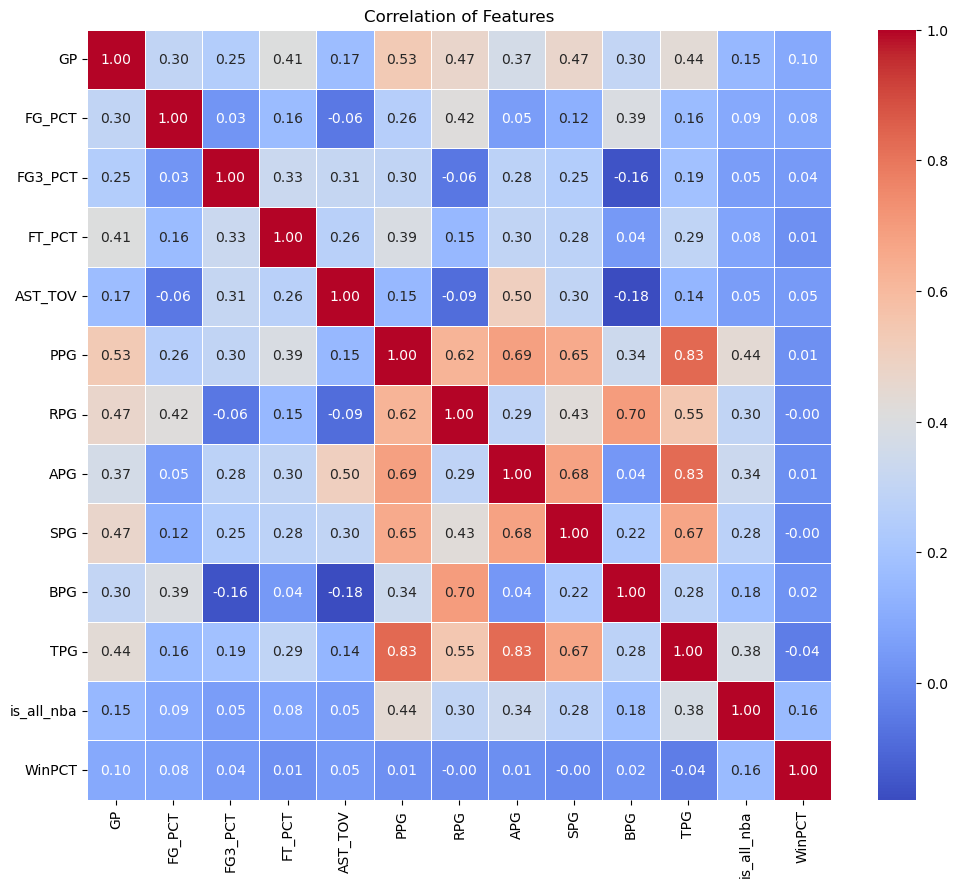

,GP,FG_PCT,FG3_PCT,FT_PCT,AST_TOV,PPG,RPG,APG,SPG,BPG,TPG,is_all_nba,WinPCT
GP,1.000000,0.299107,0.248568,0.407893,0.167417,0.530893,0.469041,0.366710,0.466689,0.303926,0.436946,0.149181,0.095572
FG_PCT,0.299107,1.000000,0.027572,0.162291,-0.058476,0.257399,0.415819,0.053705,0.120431,0.393409,0.162736,0.093028,0.079794
FG3_PCT,0.248568,0.027572,1.000000,0.331338,0.310308,0.300143,-0.061262,0.280409,0.249454,-0.159536,0.187427,0.051951,0.044364
FT_PCT,0.407893,0.162291,0.331338,1.000000,0.263472,0.390329,0.152122,0.298796,0.280114,0.040361,0.294319,0.078440,0.013828
AST_TOV,0.167417,-0.058476,0.310308,0.263472,1.000000,0.152600,-0.091196,0.503677,0.297648,-0.178677,0.140137,0.053301,0.045896
PPG,0.530893,0.257399,0.300143,0.390329,0.152600,1.000000,0.619170,0.685638,0.652911,0.339905,0.830735,0.440161,0.012643
RPG,0.469041,0.415819,-0.061262,0.152122,-0.091196,0.619170,1.000000,0.288564,0.428059,0.698565,0.546947,0.298212,-0.000149
APG,0.366710,0.053705,0.280409,0.298796,0.503677,0.685638,0.288564,1.000000,0.680423,0.036745,0.826273,0.336719,0.007802
SPG,0.466689,0.120431,0.249454,0.280114,0.297648,0.652911,0.428059,0.680423,1.000000,0.223056,0.671678,0.276715,-0.004667
BPG,0.303926,0.393409,-0.159536,0.040361,-0.178677,0.339905,0.698565,0.036745,0.223056,1.000000,0.277421,0.178371,0.020035


In [197]:
features = ['GP', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'AST_TOV', 'PPG', 'RPG', 'APG', 'SPG', 'BPG', 'TPG', 'is_all_nba', 'WinPCT']
selected_df = final_df[features]
correlation_matrix = selected_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation of Features")
plt.show()

correlation_matrix

In [198]:
features = ['GP', 'PPG', 'RPG', 'APG', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'SPG', 'BPG', 'TPG',  'is_all_nba', 'WinPCT']

X = final_df[features + ['PLAYER']  + ['YEAR']].drop('is_all_nba', axis=1)
y = final_df['is_all_nba']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

test_player_names = X_test['PLAYER'].reset_index(drop=True)
test_years = X_test['YEAR'].reset_index(drop=True)
X_train = X_train.drop('PLAYER', axis=1)
X_test = X_test.drop('PLAYER', axis=1)
X_train = X_train.drop('YEAR', axis=1)
X_test = X_test.drop('YEAR', axis=1)

## BINARY CLASSIFICATION

##### Taking our more complete data frame, we can do a few additional pre-processing steps before using a RandomForestClassifier. As one can see in the code below, splitting the data into sections before and after 2017, and using is_all_nba as our feature for our training variable, before initializing and fitting our Random Forest.

In [199]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

       False       0.99      1.00      0.99      1934
        True       0.88      0.67      0.76        52

    accuracy                           0.99      1986
   macro avg       0.93      0.84      0.88      1986
weighted avg       0.99      0.99      0.99      1986



##### We can now sort our features and plot them to give us visual reference for the importance of each

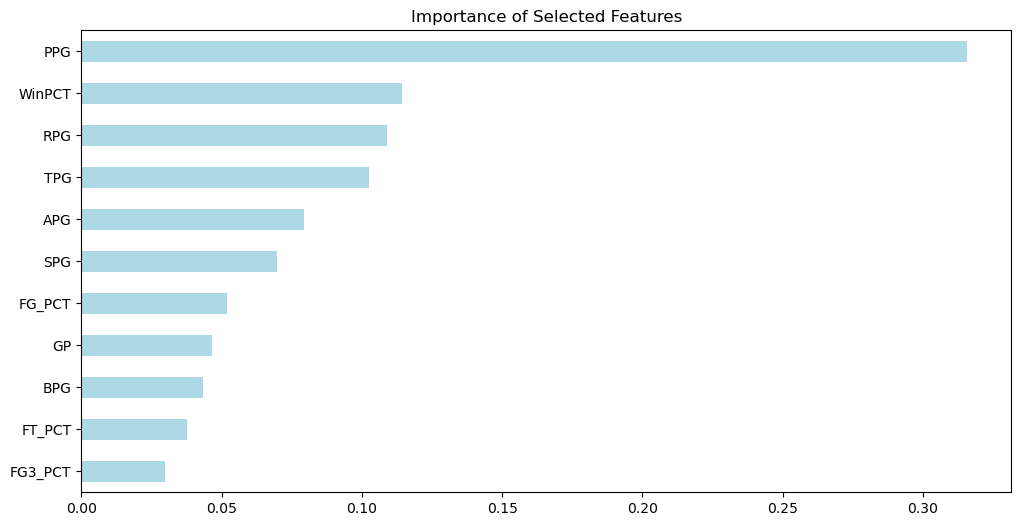

In [200]:
feature_importances = model.feature_importances_
features = X_train.columns
importances = pd.Series(feature_importances, index=features)
importances_sorted = importances.sort_values()

plt.figure(figsize=(12,6))
importances_sorted.plot(kind='barh', color='lightblue')
plt.title('Importance of Selected Features')
plt.show()


## Gradient Boost Classification

In [201]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)
print(classification_report(y_test, gb_predictions))


              precision    recall  f1-score   support

       False       0.99      0.99      0.99      1934
        True       0.79      0.73      0.76        52

    accuracy                           0.99      1986
   macro avg       0.89      0.86      0.88      1986
weighted avg       0.99      0.99      0.99      1986



In [202]:

results_df = pd.DataFrame({
    'Year': test_years,
    'Player': test_player_names,
    'Actual': y_test.reset_index(drop=True),
    'Predicted': gb_predictions
})

results_df['Comparison'] = results_df['Actual'] == results_df['Predicted']
comparisons_df = results_df[results_df['Comparison'] == False]
comparisons_df.sort_values(by=['Year', 'Player'], ascending=True)

,Year,Player,Actual,Predicted,Comparison
1755,2011-12,Andrew Bynum,True,False,False
357,2011-12,Dwyane Wade,True,False,False
20,2011-12,Rajon Rondo,True,False,False
1222,2011-12,Russell Westbrook,True,False,False
76,2011-12,Tyson Chandler,True,False,False
1101,2012-13,David Lee,True,False,False
834,2012-13,Marc Gasol,True,False,False
688,2012-13,Paul George,True,False,False
355,2013-14,Carmelo Anthony,False,True,False
1194,2013-14,Damian Lillard,True,False,False


## Random Forest with Probabilities

Below we change the approach to use 2010-2016 season data to train, and then test using 2017-2020.  The reason for this is that the post-processing approach (i.e. using the top 6 guards, 6 forwards, and 3 centers yearly only works if we have full year dataset.  

In [203]:
features = ['GP', 'PPG', 'RPG', 'APG', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'SPG', 'BPG', 'TPG',  'is_all_nba', 'WinPCT']
X = final_df[features].drop('is_all_nba', axis=1)
y = final_df['is_all_nba']

train_df = final_df[final_df['season_start_year'] < 2017]
test_df = final_df[final_df['season_start_year'] >= 2017]

X_train = train_df[features].drop('is_all_nba', axis=1)
y_train = train_df['is_all_nba']
X_test = test_df[features].drop('is_all_nba', axis=1)
y_test = test_df['is_all_nba']

In [204]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
prob_predictions = model.predict_proba(X_test)
positive_class_probs = prob_predictions[:, 1]
results_df = pd.DataFrame({
    'Player': test_df['PLAYER'],
    'Player_ID': test_df['PLAYER_ID'],
    'Position': test_df['POSITION'],
    'Year': test_df['YEAR'],
    'Actual': y_test,
    'Predicted Probability': positive_class_probs,
})
predicted_probabilities_df = results_df.sort_values(by=['Year', 'Predicted Probability'], ascending=False)

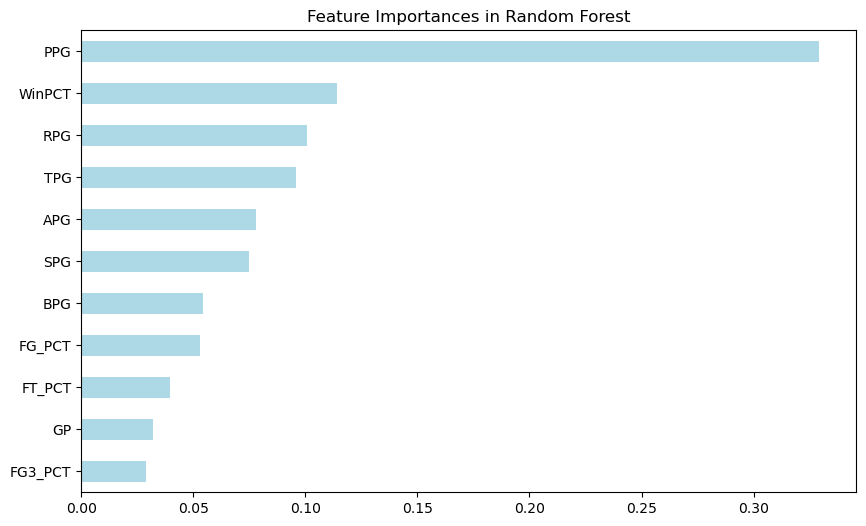

In [205]:
feature_importances = model.feature_importances_
features = X_train.columns

importances = pd.Series(feature_importances, index=features)
importances_sorted = importances.sort_values()

plt.figure(figsize=(10,6))
importances_sorted.plot(kind='barh', color='lightblue')
plt.title('Feature Importances in Random Forest')
plt.show()


We would've expected points and win percentage to play a critical part in All-NBA selections.  However, TPG is quite surprising as it's typically viewed as a negativepredicted_probabilities_df.  We suspect that the model is rewarding high turnovers because its a sign of high usage, which the best players in basketball typically will have.

In [206]:
predicted_probabilities_df

,Player,Player_ID,Position,Year,Actual,Predicted Probability
6096,Joel Embiid,203954,Center-Forward,2022-23,True,0.93
6078,Jayson Tatum,1628369,Forward-Guard,2022-23,True,0.92
6079,Jaylen Brown,1627759,Guard-Forward,2022-23,True,0.88
6151,Giannis Antetokounmpo,203507,Forward,2022-23,True,0.88
6334,Nikola Jokic,203999,Center,2022-23,True,0.88
...,...,...,...,...,...,...
3868,Timofey Mozgov,202389,Center,2017-18,False,0.00
3869,Isaiah Whitehead,1627785,Guard,2017-18,False,0.00
3870,Milton Doyle,1628495,Guard,2017-18,False,0.00
3872,James Webb III,1627821,Forward,2017-18,False,0.00


In [207]:
def mark_top_players(group):
    group['Position'] = group['Position'].fillna('')
    for position in ['Guard', 'Forward', 'Center']:
        num_to_select = 6 if position in ['Guard', 'Forward'] else 3
        top_players = group[group['Position'].str.contains(position)].nlargest(num_to_select, 'Predicted Probability')
        group.loc[top_players.index, 'Predicted_AllNBA'] = True
    return group

predicted_probabilities_df['Predicted_AllNBA'] = False
predicted_probabilities_df = predicted_probabilities_df.groupby('Year', group_keys=True).apply(mark_top_players)

In [208]:
predicted_probabilities_df['Comparison'] = predicted_probabilities_df.apply(lambda x: 'Match' if (x['Actual'] == 1 and x['Predicted_AllNBA'] == 1) or (x['Actual'] == 0 and x['Predicted_AllNBA'] == 0 ) else 'Mismatch', axis=1)

In [209]:
predicted_probabilities_df[predicted_probabilities_df['Predicted_AllNBA'] == True]

Player  Player_ID        Position     Year  Actual  \
Year                                                                          
2017-18 3334       LeBron James       2544         Forward  2017-18    True   
        3390  Russell Westbrook     201566           Guard  2017-18    True   
        3371      Anthony Davis     203076  Forward-Center  2017-18    True   
        3351       James Harden     201935           Guard  2017-18    True   
        3472       Kevin Durant     201142         Forward  2017-18    True   
...                         ...        ...             ...      ...     ...   
2022-23 6421      Anthony Davis     203076  Forward-Center  2022-23   False   
        6187      Julius Randle     203944  Forward-Center  2022-23    True   
        6203   Donovan Mitchell    1628378           Guard  2022-23    True   
        6169    Anthony Edwards    1630162           Guard  2022-23   False   
        6114        Luka Doncic    1629029   Forward-Guard  2022-23    True   

              Predicted Probability  Predicted_AllNBA Comparison  
Year                                                              
2017-18 3334                   0.91              True      Match  
        3390                   0.90              True      Match  
        3371                   0.86              True      Match  
        3351                   0.85              True      Match  
        3472                   0.85              True      Match  
...                             ...               ...        ...  
2022-23 6421                   0.72              True   Mismatch  
        6187                   0.70              True      Match  
        6203                   0.70              True      Match  
        6169                   0.61              True   Mismatch  
        6114                   0.56              True      Match  

[72 rows x 8 columns]

In [210]:
print(classification_report(predicted_probabilities_df['Actual'], predicted_probabilities_df['Predicted_AllNBA']))

              precision    recall  f1-score   support

       False       0.99      1.00      0.99      3196
        True       0.79      0.66      0.72        87

    accuracy                           0.99      3283
   macro avg       0.89      0.83      0.85      3283
weighted avg       0.99      0.99      0.99      3283



## Multiple Regression

In [211]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
prob_predictions = log_reg.predict_proba(X_test)
positive_class_probs = prob_predictions[:, 1]
results_df = pd.DataFrame({
    'Player': test_df['PLAYER'],
    'Player_ID': test_df['PLAYER_ID'],
    'Position': test_df['POSITION'],
    'Year': test_df['YEAR'],
    'Actual': y_test,
    'Predicted Probability': positive_class_probs
})

regression_predicted_probabilities_df = results_df.sort_values(by=['Year', 'Predicted Probability'], ascending=False)
regression_predicted_probabilities_df

/Users/afante/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Player,Player_ID,Position,Year,Actual,Predicted Probability
6151,Giannis Antetokounmpo,203507,Forward,2022-23,True,9.964911e-01
6114,Luka Doncic,1629029,Forward-Guard,2022-23,True,9.936162e-01
6096,Joel Embiid,203954,Center-Forward,2022-23,True,9.934885e-01
6334,Nikola Jokic,203999,Center,2022-23,True,9.886497e-01
6078,Jayson Tatum,1628369,Forward-Guard,2022-23,True,9.764027e-01
...,...,...,...,...,...,...
3521,Marcus Paige,1627779,Guard,2017-18,False,1.535559e-06
3855,Adreian Payne,203940,Forward,2017-18,False,8.164115e-07
3723,Antonius Cleveland,1628499,Guard,2017-18,False,7.203027e-07
3587,David Stockton,204065,Guard,2017-18,False,6.764405e-07


In [212]:
regression_predicted_probabilities_df['Predicted_AllNBA'] = False
regression_predicted_probabilities_df = regression_predicted_probabilities_df.groupby('Year', group_keys=True).apply(mark_top_players)

In [213]:
regression_predicted_probabilities_df

Player  Player_ID        Position     Year  \
Year                                                                      
2017-18 3351           James Harden     201935           Guard  2017-18   
        3334           LeBron James       2544         Forward  2017-18   
        3390      Russell Westbrook     201566           Guard  2017-18   
        3371          Anthony Davis     203076  Forward-Center  2017-18   
        3407  Giannis Antetokounmpo     203507         Forward  2017-18   
...                             ...        ...             ...      ...   
2022-23 6541             Khem Birch     203920          Center  2022-23   
        6252           Tony Bradley    1628396  Center-Forward  2022-23   
        6614          Buddy Boeheim    1631205         Forward  2022-23   
        6364         Trevor Hudgins    1631309           Guard  2022-23   
        6615            Braxton Key    1630296         Forward  2022-23   

              Actual  Predicted Probability  Predicted_AllNBA  
Year                                                           
2017-18 3351    True           9.898067e-01              True  
        3334    True           9.885379e-01              True  
        3390    True           9.823307e-01              True  
        3371    True           9.774674e-01              True  
        3407    True           9.535457e-01              True  
...              ...                    ...               ...  
2022-23 6541   False           7.569554e-07             False  
        6252   False           6.074157e-07             False  
        6614   False           4.526206e-07             False  
        6364   False           3.993221e-07             False  
        6615   False           1.073904e-07             False  

[3283 rows x 7 columns]

In [214]:
print(classification_report(regression_predicted_probabilities_df['Actual'], regression_predicted_probabilities_df['Predicted_AllNBA']))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99      3196
        True       0.76      0.63      0.69        87

    accuracy                           0.99      3283
   macro avg       0.88      0.81      0.84      3283
weighted avg       0.98      0.99      0.98      3283

